## Carregamento e preparo dos dados

In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import optuna
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from linear_assignment import linear_assignment
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl

In [2]:
raw_data = pd.read_csv('yeast.data',
                       sep = '\s+',
                       header=None,
                       names=["Sequence Name","mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "label"]
                      )
raw_data.head()

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,label
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


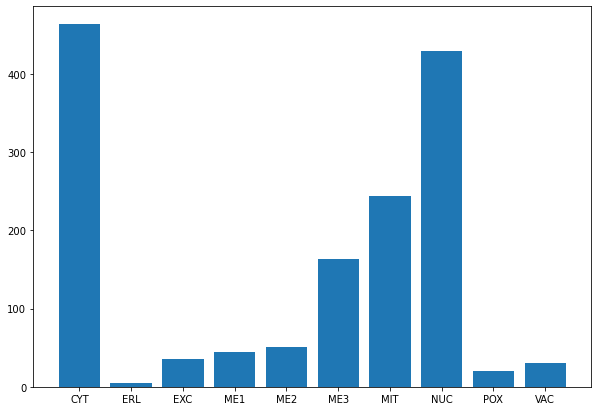

In [3]:
labels, count = np.unique(raw_data["label"], return_counts=True)
plt.figure(figsize=(10,7))
plt.bar(labels, count);

#### Descartando os atributos categóricos:

In [4]:
labelEnc = LabelEncoder()
label = raw_data["label"]
y = labelEnc.fit_transform(raw_data["label"])

In [5]:
df = raw_data.drop(columns=["Sequence Name", "label"])
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


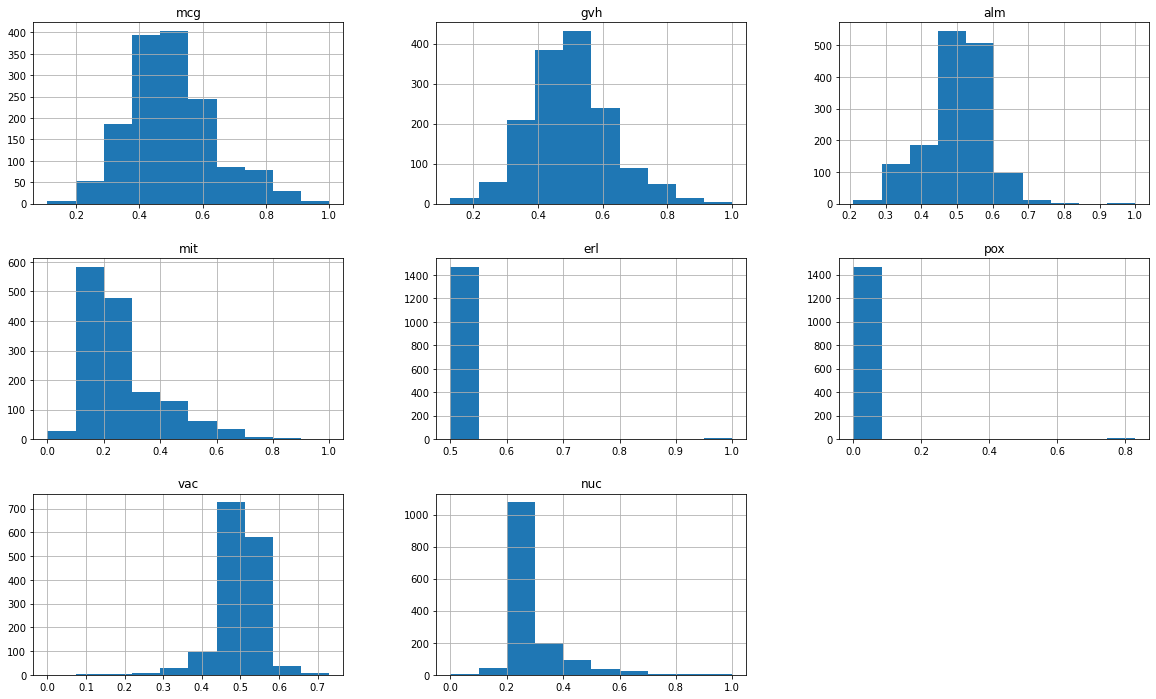

In [6]:
df.hist(figsize=(20,12));

In [7]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


Sem dados faltantes

In [8]:
df.isna().sum()

mcg    0
gvh    0
alm    0
mit    0
erl    0
pox    0
vac    0
nuc    0
dtype: int64

## FCM-DFCV
#### A fuzzy clustering method based on an adaptive quadratic distance for each cluster defined by a diagonal fuzzy covariance matrix

#### Conceito:

É utilizado uma função softmax na inicialização aleatória de U, pois é ideal que a matriz U tenha  $\sum_{i=1}^{c} u_{ik} = 1$, ou seja, a soma dos graus de pertinência de uma amostra para todas as classe tem que ser 1.

In [9]:
3 * np.random.rand(2, 2)

array([[0.92965627, 1.83684422],
       [0.40732146, 1.56933759]])

In [42]:
softmax(1 * np.random.rand(2, 2), axis=0)

array([[0.33959406, 0.57209013],
       [0.66040594, 0.42790987]])

#### Classe do modelo:


In [8]:
class FCM_DFCV:
    def __init__(self, n_class, m, T, epsilon, rand_value_init_U, mim_distance=0.00001):
        self.n_class = n_class
        self.m = m
        self.T = T
        self.epsilon = epsilon
        self.mim_distance = mim_distance
        self.rand_value_init_U = rand_value_init_U
        self.loss = []

    def fit(self, df):

        self.n = df.shape[0]
        self.p = df.shape[1]

        for i in range(self.T):

            if i == 0:

                # Inicializacao da matriz de perminência aleatória
                U = self.init_U_random()
                # G_anterior interacao 0
                G = np.zeros([self.n_class, self.p])
                M = np.zeros([self.n_class, self.p, self.p])
                J = np.inf
                self.J_best = J

            else:
                # Calculo da matriz de pertinência
                U = self.calc_U(D_M)
                # break

            # Calculo dos prototipos
            G = self.calc_G(df, U, G)
            # import pdb;pdb.set_trace()

            M = self.calc_M(U, df, G, M)
            # Calculo das distâncias quadraticas
            D_M = self.calc_D_M(df, G, M)

            # Calculo da função de custo
            J_ant = J
            J = self.calc_J(U, D_M)
            # self.plot(G)

            self.loss.append(J)
            if self.J_best > J:
                self.J_best = J
                self.U = U
                self.G = G

            if np.abs(J - J_ant) < self.epsilon:
                break

    def plot(self, G):
        colors = cm.rainbow(np.linspace(0, 1, len(range(self.n_class))))
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))
        axs[0, 0].scatter(G[:, 0], G[:, 1], c=colors)
        axs[0, 0].set_title("Feature 0-1")
        axs[0, 1].scatter(G[:, 2], G[:, 3], c=colors)
        axs[0, 1].set_title("Feature 2-3")
        axs[1, 0].scatter(G[:, 4], G[:, 5], c=colors)
        axs[1, 0].set_title("Feature 4-5")
        axs[1, 1].scatter(G[:, 6], G[:, 7], c=colors)
        axs[1, 1].set_title("Feature 6-7")
        plt.show()

    # Inicialização aleatoria da matrix de pertinencia U
    def init_U_random(self):
        return softmax(
            self.rand_value_init_U * np.random.rand(self.n_class, self.n), axis=0
        )

    def calc_U(self, D_M):
        U = np.zeros([self.n_class, self.n])
        for k in range(self.n):

            argmin_values = np.argwhere(D_M[:, k] < self.mim_distance)

            if len(argmin_values) > 0:
                i = argmin_values[0][0]
                U[:, k] = 0
                U[i, k] = 1
            else:

                for i in range(self.n_class):
                    U[i, k] = np.around(
                        (((D_M[i, k] / D_M[:, k]) ** (1 / (self.m - 1))).sum()) ** (-1),
                        decimals=6,
                    )

        return U

    def calc_G(self, df, U, G_ant):
        G = np.zeros([self.n_class, self.p])
        U_m = U ** self.m

        for i in range(self.n_class):

            U_i = U_m[i, :].reshape([self.n, 1])
            # Formula (3)
            U_i_sum = U_i.sum()

            if U_i_sum > 0.000001:
                G[i, :] = (U_i * df).sum(axis=0) / U_i_sum
            else:
                G[i, :] = G_ant[i, :]

        return G

    def calc_J(self, U, D_M):
        U_m = U ** self.m
        J = (U_m * D_M).sum()
        return J

    def calc_M(self, U, df, G, M_ant):
        U_m = U ** self.m
        M = np.zeros([self.n_class, self.p, self.p])

        for i in range(self.n_class):

            U_i = U_m[i, :].reshape([self.n, 1])
            sum_features = (U_i * (df - G[i]) ** 2).sum()
            lambda_i = (
                np.prod((U_i * (df - G[i]) ** 2).sum(axis=0) ** (1 / self.p))
                / sum_features
            )
            M_i = np.diag(lambda_i)

            if np.isnan(M_i).sum() > 0:
                M_i = M_ant[i]

            M[i, :, :] = M_i

        return M

    def calc_D_M(self, df, G, M):
        D_M = np.zeros([self.n_class, self.n])
        df_ = df.to_numpy()
        for k in range(self.n):
            for i in range(self.n_class):
                x_k = df_[k].reshape([1, self.p])
                g_i = G[i]
                M_i = M[i]

                # A matriz transposta foi utilizada no ultimo termo
                # pois o x_k já está no formato (1,p)
                # e será feito o produto matricial com M que é no formato (p, p)
                parcial = np.dot((x_k - g_i), M_i)
                D_M[i, k] = np.dot(parcial, (x_k - g_i).T)

        return D_M


### Métricas

#### Modified Partition Coeficient

In [12]:
def Partition_Coefficient(U, N):
    return (U ** 2).sum()/ N

def Modified_Partition_Coefficient(U, K, N):
    PC = Partition_Coefficient(U, N)
    return 1 - K/(K - 1)*(1 - PC)

#### Partition Coefficient

In [13]:
def Partition_Entropy(U, N):
    return -1/N * (U * np.log2(U + 0.000001)).sum()

#### Adjusted Rand Score

Utilizando adjusted_rand_score do Sklearn

#### F-Measure

In [14]:
def F_measure(cf_m):
    n_i = cf_m.sum(axis=0)
    n_j = cf_m.sum(axis=1)
    F = 0
    for j in range(K):
        n_ij = cf_m[j, :]
        max_value = np.nanmax( ( n_ij / n_i *  n_ij / n_j[j])/ (  n_ij / n_i +  n_ij / n_j[j] ))
        F += n_j[j] / N * max_value
    return F

### Busca pelos melhores parâmetros

#### Hiperparâmetros

In [40]:
N = df.shape[0]
K = 10

In [19]:
parameters = {
    "m": [1.1, 1.6, 2.0],
    "c": [10],
    "T": [150],
    "epsilon": [10e-10],
    "rand_value_init_U": list(range(1,101)) # 100 inicializaçoes aleatorias
}

In [20]:
def objective(trial):
    
    ##  Parametros ####
    m = trial.suggest_float("m", 1.1, 10)
    epsilon = trial.suggest_float("epsilon", 0, 1)
    T = trial.suggest_int("T", 100, 150)
    c = trial.suggest_int("c", 10, 10)
    rand_value_init_U = trial.suggest_int("rand_value_init_U", 1, 100)

    #  Modelo ####
    model = FCM_DFCV(n_class=c, m=m, T=T, epsilon=epsilon, rand_value_init_U=rand_value_init_U)
    model.fit(df)
    J = model.J_best
    trial.set_user_attr(key="J", value = J)

    trial.set_user_attr(key="model", value=model)
    U = model.U
    
    # Métricas ###############

    # Modified_Partition_Coefficient
    mod_part_coef = Modified_Partition_Coefficient(U, K, N)
    trial.set_user_attr(key="mod_part_coef", value = mod_part_coef)
    
    # Partition_Entropy
    part_entropy = Partition_Entropy(U, N)
    trial.set_user_attr(key="part_entropy", value = part_entropy)

    
    ### Criação da representação CRISP
    U_predict_crisp = np.argmax(U, axis=0)
    
    # adjusted_rand_score
    # y é a prediçao correta dos dados 
    adjusted_rand = adjusted_rand_score(y, U_predict_crisp)
    trial.set_user_attr(key="adjusted_rand", value = adjusted_rand)
    
    #Calculo da f_measure
    confu_matrix = confusion_matrix(y, U_predict_crisp)
    f_measure = F_measure(confu_matrix)
    trial.set_user_attr(key="f-measure", value = f_measure)

    return J




def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(
            key="best_model", value=trial.user_attrs["model"]
        )
    
study = optuna.create_study(sampler=optuna.samplers.GridSampler(parameters))
study.optimize(objective, callbacks=[callback])

[I 2021-07-30 22:43:32,704] A new study created in memory with name: no-name-72f9f413-d550-43bf-ab35-4c93f1fcaefc
[I 2021-07-30 22:44:11,637] Trial 0 finished with value: 0.19785645054344553 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 26}. Best is trial 0 with value: 0.19785645054344553.
[I 2021-07-30 22:44:31,173] Trial 1 finished with value: 13.214772259040041 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 5}. Best is trial 0 with value: 0.19785645054344553.
[I 2021-07-30 22:44:54,221] Trial 2 finished with value: 0.539798732117927 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 67}. Best is trial 0 with value: 0.19785645054344553.
[I 2021-07-30 22:45:50,939] Trial 3 finished with value: 3.128923635308486 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 42}. Best is trial 0 with value: 0.19785645054344553.
[I 2021-07-30 22:46:32,176] 

[I 2021-07-30 23:07:01,976] Trial 36 finished with value: 7.841821005898758 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 84}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:07:49,390] Trial 37 finished with value: 0.6234713231020702 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 36}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:08:25,223] Trial 38 finished with value: 0.7801774888851838 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 59}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:08:55,969] Trial 39 finished with value: 0.13654732466681443 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 15}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:09:41,630] Trial 40 finished with value: 1.9577247354914191 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 

[I 2021-07-30 23:31:43,972] Trial 72 finished with value: 3.7610310641180926 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 80}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:32:35,017] Trial 73 finished with value: 2.3664644125208376 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 86}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:33:29,930] Trial 74 finished with value: 0.5038535133846813 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 22}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:33:55,272] Trial 75 finished with value: 0.3488051765687867 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 28}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:34:13,473] Trial 76 finished with value: 0.7745892456099273 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 

[I 2021-07-30 23:57:27,829] Trial 108 finished with value: 2.963284353578894 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 82}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:57:59,863] Trial 109 finished with value: 0.6985373285255836 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 60}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:58:24,423] Trial 110 finished with value: 0.2554465547438335 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 18}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:59:16,780] Trial 111 finished with value: 0.4769301258597118 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 48}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-30 23:59:43,772] Trial 112 finished with value: 17.36416208113156 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 15

[I 2021-07-31 00:20:21,664] Trial 144 finished with value: 9.05785910523334 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 51}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:20:42,580] Trial 145 finished with value: 22.57438833317181 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 15}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:21:34,106] Trial 146 finished with value: 18.88863580765414 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 33}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:21:56,756] Trial 147 finished with value: 0.321976146420352 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 7}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:22:46,890] Trial 148 finished with value: 0.640189593324459 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c

[I 2021-07-31 00:42:15,548] Trial 180 finished with value: 9.190107087529356 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 75}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:42:41,176] Trial 181 finished with value: 7.95259427039635 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 29}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:42:45,889] Trial 182 finished with value: 6.1553636143081585 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 90}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:43:10,182] Trial 183 finished with value: 1.95496518168654 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 32}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 00:43:34,080] Trial 184 finished with value: 18.308934053396413 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 

[I 2021-07-31 01:02:30,239] Trial 216 finished with value: 0.5799987492927474 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 41}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:02:57,795] Trial 217 finished with value: 0.3978286248802119 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 3}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:03:43,912] Trial 218 finished with value: 1.7954936592281665 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 94}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:04:35,468] Trial 219 finished with value: 2.939814407273654 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 36}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:05:17,326] Trial 220 finished with value: 0.5161848868606462 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 15

[I 2021-07-31 01:24:35,338] Trial 252 finished with value: 14.559199108992225 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 43}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:24:52,638] Trial 253 finished with value: 6.830275115407197 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 36}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:25:44,733] Trial 254 finished with value: 2.824566683937338 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 18}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:26:37,036] Trial 255 finished with value: 18.839109266981268 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 80}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:26:45,595] Trial 256 finished with value: 2.504178368972491 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150

[I 2021-07-31 01:46:56,937] Trial 288 finished with value: 0.6978244691424034 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 32}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:47:45,578] Trial 289 finished with value: 0.6848916234235525 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 75}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:48:00,093] Trial 290 finished with value: 0.3056443187420056 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 38}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:48:23,922] Trial 291 finished with value: 0.6041869963000044 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 23}. Best is trial 14 with value: 0.06473284342663625.
[I 2021-07-31 01:49:15,414] Trial 292 finished with value: 2.1949223789159573 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 

In [21]:
pkl.dump(study, open("study_optuna.pkl",'wb'))

In [9]:
study = pkl.load(open("study_optuna.pkl", "rb"))

Encontrar o menor J para cada um dos valores de m avaliados

In [11]:
for param_m in [1.1, 1.6, 2.0]:
    trial_m = []
    j = []
    fmeasures = []
    mod_part_coef = []
    part_entropy = []
    adjusted_rand = []

    for trial in study.trials:


        if trial.params["m"] == param_m:
            trial_m.append(trial.number)
            j.append(trial.user_attrs['J'])
            
            fmeasures.append(trial.user_attrs['f-measure'])
            mod_part_coef.append(trial.user_attrs['mod_part_coef'])
            part_entropy.append(trial.user_attrs['part_entropy'])
            adjusted_rand.append(trial.user_attrs['adjusted_rand'])
    print("m:", param_m,", best TRIAL :", trial_m[np.argmin(j)] )
    print("J", np.min(j))
   
    print("modified Partition Coefficient", mod_part_coef[np.argmin(j)])
    print("partition Entropy", part_entropy[np.argmin(j)])
    print("F-Measure", fmeasures[np.argmin(j)])
    print("adjusted rand", adjusted_rand[np.argmin(j)])
    print("w initialized",study.trials[trial_m[np.argmin(j)]].params["rand_value_init_U"])
    print("------------------------------------------")

m: 1.1 , best TRIAL : 160
J 1.1049396828808704
modified Partition Coefficient 0.9996791026488798
partition Entropy 0.0008252851676628058
F-Measure 0.18248089666258172
adjusted rand 0.010195875617439287
w initialized 93
------------------------------------------
m: 1.6 , best TRIAL : 87
J 0.4499386317391912
modified Partition Coefficient 0.9625547748803475
partition Entropy 0.11267709780650871
F-Measure 0.1818590927703515
adjusted rand 0.013080939539866124
w initialized 22
------------------------------------------
m: 2.0 , best TRIAL : 14
J 0.06473284342663625
modified Partition Coefficient 0.9818429562243635
partition Entropy 0.08018545864109006
F-Measure 0.17879517873371695
adjusted rand 0.008875514422974145
w initialized 98
------------------------------------------


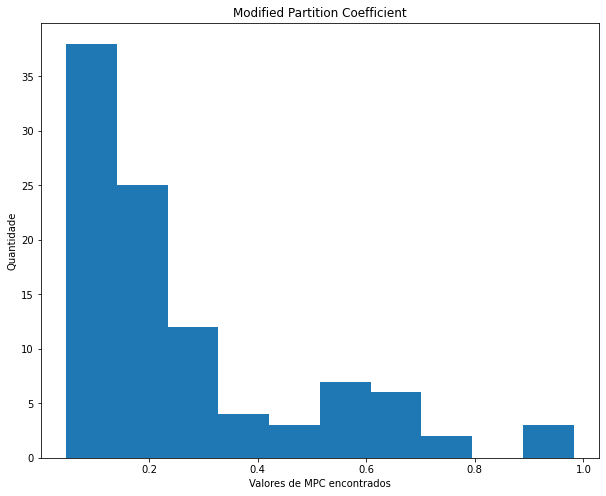

In [12]:
plt.figure(figsize=(10,8))
plt.hist(mod_part_coef)
plt.title("Modified Partition Coefficient")
plt.xlabel("Valores de MPC encontrados")
plt.ylabel("Quantidade");

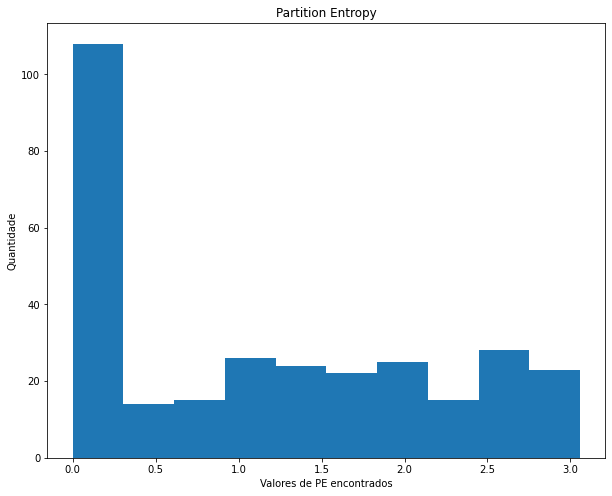

In [12]:
plt.figure(figsize=(10,8))
plt.hist(part_entropy)
plt.title("Partition Entropy")
plt.xlabel("Valores de PE encontrados")
plt.ylabel("Quantidade");

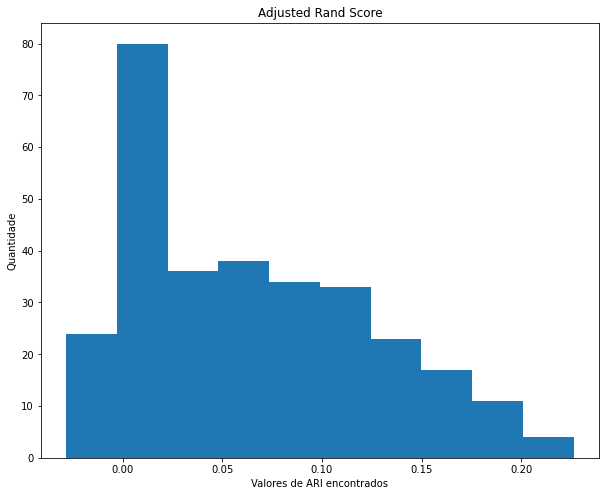

In [13]:
plt.figure(figsize=(10,8))
plt.hist(adjusted_rand)
plt.title("Adjusted Rand Score")
plt.xlabel("Valores de ARI encontrados")
plt.ylabel("Quantidade");

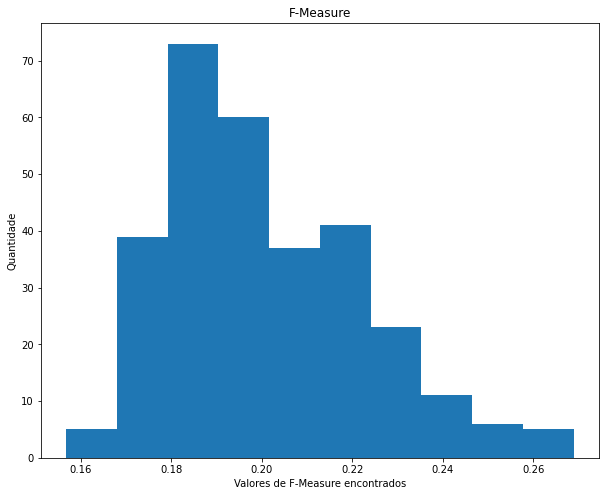

In [14]:
plt.figure(figsize=(10,8))
plt.hist(fmeasures)
plt.title("F-Measure")
plt.xlabel("Valores de F-Measure encontrados")
plt.ylabel("Quantidade");

In [13]:
fmeasures = []
mod_part_coef = []
part_entropy = []
adjusted_rand = []
j = []
for trial in study.trials:
    fmeasures.append(trial.user_attrs['f-measure'])
    mod_part_coef.append(trial.user_attrs['mod_part_coef'])
    part_entropy.append(trial.user_attrs['part_entropy'])
    adjusted_rand.append(trial.user_attrs['adjusted_rand'])
    j.append(trial.user_attrs['J'])
    #print(f"F-measure = {}")
print("best TRIAL F-Measure", np.argmax(fmeasures))
print("best TRIAL modified Partition Coefficient", np.argmax(mod_part_coef))
print("best TRIAL partition Entropy", np.argmin(part_entropy))
print("best TRIAL adjusted rand", np.argmax(adjusted_rand))
print("best TRIAL J", np.argmin(j))

best TRIAL F-Measure 94
best TRIAL modified Partition Coefficient 226
best TRIAL partition Entropy 226
best TRIAL adjusted rand 10
best TRIAL J 14


In [15]:
for trial in study.trials:
    print(f"trial {trial.number}, params={{'m':{trial.params['m']},'rand_init_U':{trial.params['rand_value_init_U']}}}")
    print(f"Modified Partition Coefficient = {trial.user_attrs['mod_part_coef']}")
    print(f"Partition Entropy = {trial.user_attrs['part_entropy']}")
    print(f"Adjusted Rand = {trial.user_attrs['adjusted_rand']}")
    print(f"F-measure = {trial.user_attrs['f-measure']}")
    print(f"J = {trial.user_attrs['J']}")
    print('\n------\n')

trial 0, params={'m':2.0,'rand_init_U':26}
Modified Partition Coefficient = 0.7008371065886568
Partition Entropy = 0.9774150552518809
Adjusted Rand = 0.008793235520342004
F-measure = 0.181851690246524
J = 0.19785645054344553

------

trial 1, params={'m':1.1,'rand_init_U':5}
Modified Partition Coefficient = 0.9469403473332877
Partition Entropy = 0.12012366956048622
Adjusted Rand = 0.15294300294382962
F-measure = 0.23142970441347874
J = 13.214772259040041

------

trial 2, params={'m':2.0,'rand_init_U':67}
Modified Partition Coefficient = 0.30865890444174005
Partition Entropy = 2.094746683775129
Adjusted Rand = 0.0022671801116933947
F-measure = 0.17870959149596016
J = 0.539798732117927

------

trial 3, params={'m':1.6,'rand_init_U':42}
Modified Partition Coefficient = 0.4847162357757584
Partition Entropy = 1.3650611167256783
Adjusted Rand = 0.16487546822697113
F-measure = 0.24574669785545905
J = 3.128923635308486

------

trial 4, params={'m':2.0,'rand_init_U':1}
Modified Partition Coe

## Melhor partição

Uso de 160 para a partição com melhor resultado considerando a função de custo.

Uso de 94 para a partição com maior F-Measure

In [71]:
i_best_trial = 160
best_trial = study.trials[i_best_trial]

In [72]:
best_trial.params

{'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 93}

In [73]:
best_model = best_trial.user_attrs["model"]

In [74]:
U = best_model.U
G = best_model.G

#### i) Posições dos protótipos

In [75]:
K=10
for i in range(K):
    print(f"Protótipo {i}: ", end='')
    for p in range(8):
        print(f"{round(G[i,p], 7)}, ", end='')
    print("")

Protótipo 0: 0.3700515, 0.3965985, 0.5166745, 0.2732405, 1.0, 0.0, 0.5199821, 0.356716, 
Protótipo 1: 0.4601412, 0.4700937, 0.440033, 0.1798969, 1.0, 0.0, 0.4600069, 0.22, 
Protótipo 2: 0.5205585, 0.5502299, 0.3903283, 0.0897047, 1.0, 0.0, 0.5497373, 0.2499015, 
Protótipo 3: 0.5299997, 0.4100297, 0.500003, 0.2400168, 1.0, 0.0, 0.4700025, 0.22, 
Protótipo 4: 0.5599872, 0.5699951, 0.6299901, 0.3900127, 1.0, 0.0, 0.5899901, 0.3999822, 
Protótipo 5: 0.7751022, 0.7468409, 0.4833272, 0.2804377, 1.0, 0.0, 0.5334252, 0.2416976, 
Protótipo 6: 0.4990979, 0.4991339, 0.500087, 0.2614244, 0.5, 0.0012867, 0.4994924, 0.2764582, 
Protótipo 7: 0.4938057, 0.494623, 0.5047869, 0.2592657, 0.5017497, 0.0215713, 0.4960859, 0.2724651, 
Protótipo 8: 0.519437, 0.5076736, 0.5019679, 0.2402068, 0.5, 0.8247989, 0.518832, 0.238869, 
Protótipo 9: 0.4498866, 0.4100589, 0.4900001, 0.1400108, 1.0, 0.0, 0.5300225, 0.300057, 


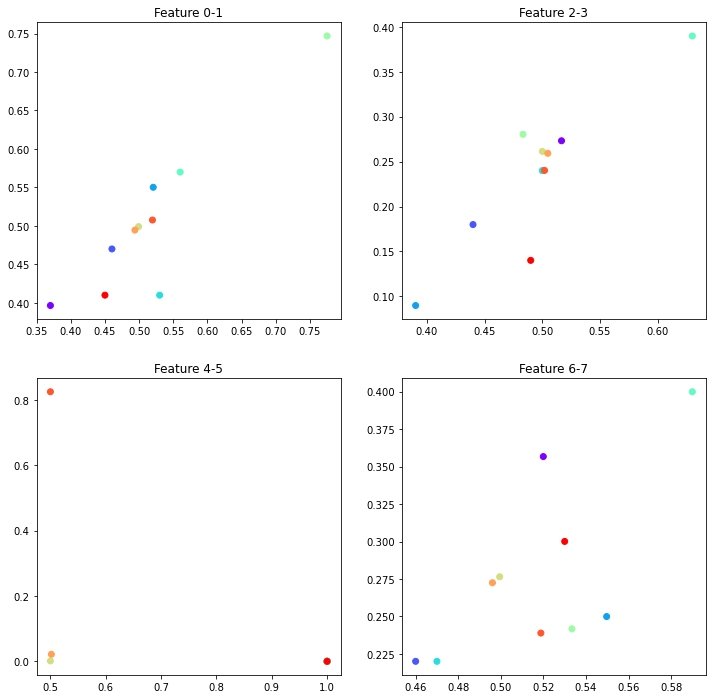

In [76]:
best_model.plot(G)

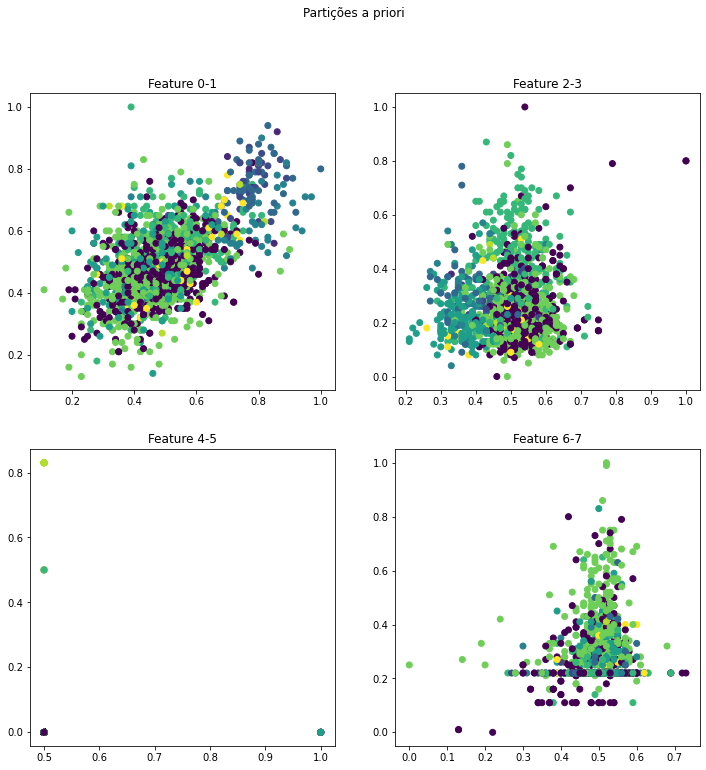

In [77]:
U_crisp = np.argmax(U, axis=0)
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Partições a priori')
axs[0, 0].scatter(df.iloc[:,0], df.iloc[:,1], c=y)
axs[0, 0].set_title('Feature 0-1')
axs[0, 1].scatter(df.iloc[:,2], df.iloc[:,3], c=y)
axs[0, 1].set_title('Feature 2-3')
axs[1, 0].scatter(df.iloc[:,4], df.iloc[:,5], c=y)
axs[1, 0].set_title('Feature 4-5')
axs[1, 1].scatter(df.iloc[:,6], df.iloc[:,7], c=y)
axs[1, 1].set_title('Feature 6-7')
plt.show();

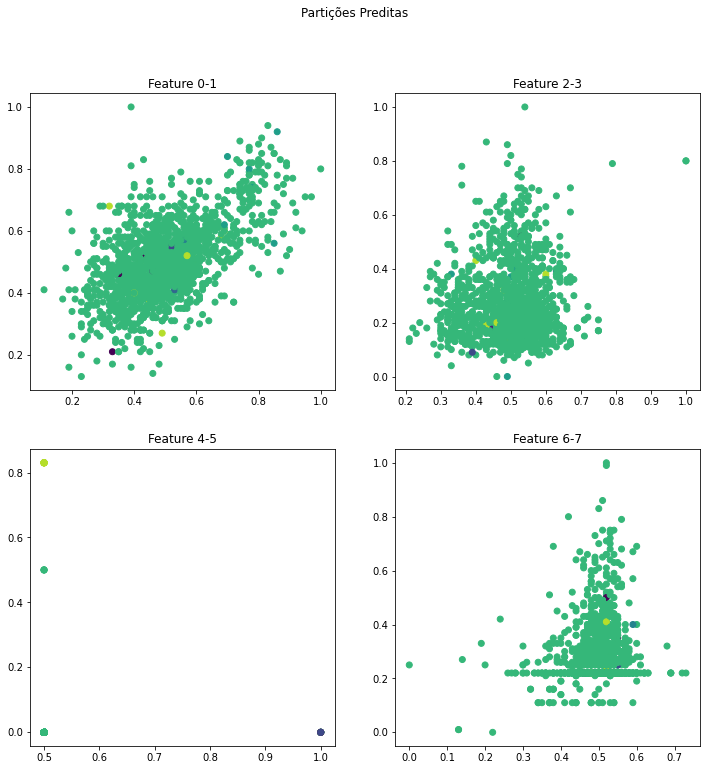

In [78]:
U_crisp = np.argmax(U, axis=0)
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Partições Preditas')
axs[0, 0].scatter(df.iloc[:,0], df.iloc[:,1], c=U_crisp)
axs[0, 0].set_title('Feature 0-1')
axs[0, 1].scatter(df.iloc[:,2], df.iloc[:,3], c=U_crisp)
axs[0, 1].set_title('Feature 2-3')
axs[1, 0].scatter(df.iloc[:,4], df.iloc[:,5], c=U_crisp)
axs[1, 0].set_title('Feature 4-5')
axs[1, 1].scatter(df.iloc[:,6], df.iloc[:,7], c=U_crisp)
axs[1, 1].set_title('Feature 6-7')
plt.show();

In [79]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df, y=y)

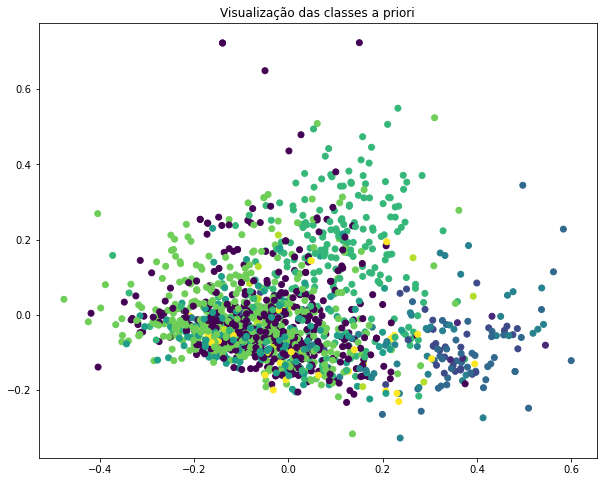

In [80]:
plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0], df_pca[:,1], c=y,)
plt.title("Visualização das classes a priori");

In [81]:
np.unique(U_crisp, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 8, 9]),
 array([   3,    1,    1,    1,    1,    6, 1459,   11,    1]))

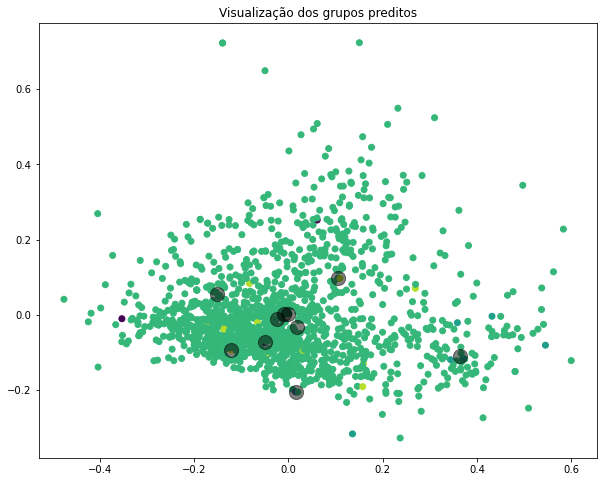

In [82]:
U_crisp = np.argmax(U, axis=0)
plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0], df_pca[:,1], c=U_crisp)
plt.scatter(pca.transform(G)[:,0], pca.transform(G)[:, 1], c='black', s=200, alpha=0.5);

plt.title("Visualização dos grupos preditos");

#### ii) Matriz Confusão

In [83]:
cf_matrix = pd.DataFrame(
    confusion_matrix(y, U_crisp),
    index=labelEnc.inverse_transform(list(range(10))),
    columns=[f"Part_{i}" for i in range(10)]
)

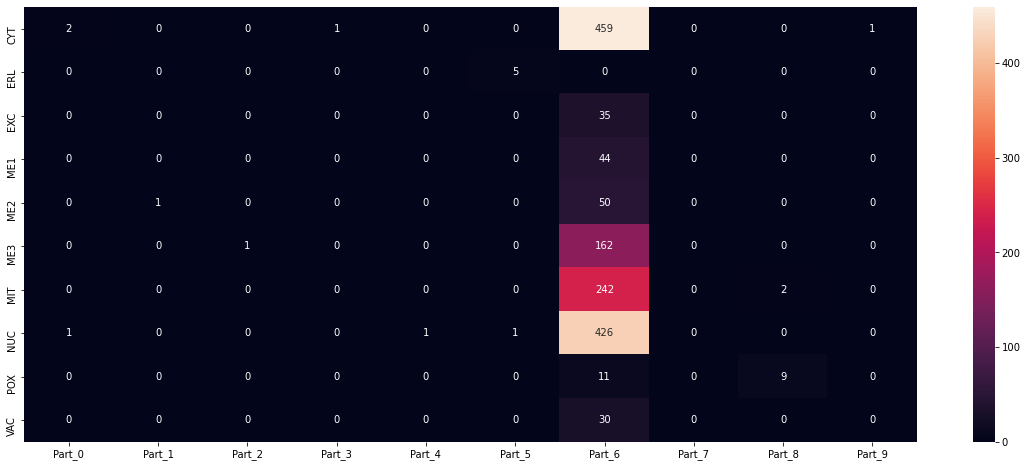

In [84]:
import seaborn as sns
plt.figure(figsize=(20,8))
sns.heatmap(cf_matrix, annot=True, fmt='');

#### iii) Modified partition coefficient

In [85]:
print("Modified partition coefficient:", best_trial.user_attrs["mod_part_coef"])

Modified partition coefficient: 0.9996791026488798


#### iv)  Partition entropy

In [86]:
print("Partition entropy:", best_trial.user_attrs["part_entropy"])

Partition entropy: 0.0008252851676628058


#### v) Indice de Rand corrigido, a F-measure e erro de classificação

Cálculo da acurácia

In [87]:
cf_m = confusion_matrix(y, U_crisp)

def Accuracy(cf_m):
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    indexes = linear_assignment(_make_cost_m(cf_m))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cf_m[:, js]
    acc = np.trace(cm2) / np.sum(cm2)
    return acc

acc = Accuracy(cf_m)

Cálculo do overall error rate of classification (OERC)

In [101]:
def OERC(cf_m):
    n_j = cf_m.sum(axis=1)
    result = 0
    for j in range(K):
        n_ij = cf_m[j, :]
        max_value = 1 - np.nanmax(n_ij / n_j[j])
        result += n_j[j] / N * max_value
        
    return result
oerc_result = OERC(cf_m)

In [102]:
print("Indice de Rand corrigido:", best_trial.user_attrs["adjusted_rand"])

Indice de Rand corrigido: 0.010195875617439287


In [103]:
print("F-measure:", best_trial.user_attrs["f-measure"])

F-measure: 0.18248089666258172


In [104]:
print("Acurácia:", acc)

Acurácia: 0.32075471698113206


In [105]:
print("Erro de Classificação (OERC):", oerc_result)

Erro de Classificação (OERC): 0.013477088948787073
